# **SEBAL Analysis of Daily ETa Rasters**

In [1]:

# Loading packages
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import box
from sklearn.linear_model import LinearRegression
from scipy.stats import linregress
from scipy.stats import variation,zscore
import xarray as xr
import rioxarray as rxr
import rasterio as rio
from rasterio.enums import Resampling
from rasterio.merge import merge
from rioxarray.merge import merge_arrays
from rasterio.warp import reproject, Resampling, calculate_default_transform
from rasterio.plot import show
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import math
import random
import seaborn as sns
import itertools

# Loading geocube to raterize vector polygons (https://github.com/corteva/geocube)
from geocube.api.core import make_geocube

import spyndex
import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep
import tarfile
import pathlib
#import geowombat




import glob
import os
import os.path
import sys

In [2]:
# Import SPAEF Function from https://github.com/cuneyd/spaef
import SPAEF_metric as sp

In [3]:
# import required modules
import numpy as np
from scipy.stats import variation,zscore
import math
######################################################################################################################
def filter_nan(s,o):
    data = np.transpose(np.array([s.flatten(),o.flatten()]))
    data = data[~np.isnan(data).any(1)]
    return data[:,0], data[:,1]
######################################################################################################################
def SPAEF(s, o):
    #remove NANs    
    s,o = filter_nan(s,o)
    
    bins_float=np.around(math.sqrt(len(o)),0)
    bins=int(bins_float)
    #compute corr coeff
    alpha = np.corrcoef(s,o)[0,1]
    #compute ratio of CV
    beta = variation(s)/variation(o)
    #compute zscore mean=0, std=1
    o=zscore(o)
    s=zscore(s)
    #compute histograms
    hobs,binobs = np.histogram(o,bins)
    hsim,binsim = np.histogram(s,bins)
    #convert int to float, critical conversion for the result
    hobs=np.float64(hobs)
    hsim=np.float64(hsim)
    #find the overlapping of two histogram      
    minima = np.minimum(hsim, hobs)
    #compute the fraction of intersection area to the observed histogram area, hist intersection/overlap index   
    gamma = np.sum(minima)/np.sum(hobs)
    #compute SPAEF finally with three vital components
    spaef = 1- np.sqrt( (alpha-1)**2 + (beta-1)**2 + (gamma-1)**2 )  

    return spaef, alpha, beta, gamma
######################################################################################################################

In [4]:
# Insert Start of data directory 
# path_data = "../../DATA_MesoHyd_MA-SEBAL/"   # Path data SC_UL
path_data = "D:/Nicolas_D/Geodaten/Masterarbeit/DATA_MesoHyd_MA-SEBAL/" # Path data NICOLAS-PC



In [5]:
# Set date(s) of modelling/data retrieval
# date = "2015-07-04"  # Initial LS Picture
date = "2020-09-19"
date = pd.to_datetime(date, format = "%Y-%m-%d")
print("Date normal =", date)


# Date in meteo_raster_daily Path Format
date_met = date.date()
date_met = date_met.strftime('%Y-%m-%d')
print("Date INTERMET =", date_met)


# Date in WASIM-Raster Path Format
date_wasim = date.date()
date_wasim = date_wasim.strftime('%Y_%m_%d').replace("_0", "_").replace("_", "_")
print("Date WASIM =", date_wasim)


# Date in ETp-FAO56-Raster Path Format
date_etp = date.date()
date_etp = date_etp.strftime('%Y_%m_%d').replace("_0", "-").replace("_", "-")
print("Date ETp =", date_etp)


# Date SSEB Format
date_SSEB = date.date()
date_SSEB = date_SSEB.strftime('%Y_%m_%d').replace("-", "_")
print("Date SSEB =", date_SSEB)

# Date in Landsat Path Format
date_LS = date.date()
date_LS = date_LS.strftime('%Y%m%d')
print("Date Landsat =", date_LS)


Date normal = 2019-06-29 00:00:00
Date INTERMET = 2019-06-29
Date WASIM = 2019_6_29
Date ETp = 2019-6-29
Date SSEB = 2019_06_29
Date Landsat = 20190629


# Import Data

### Import Catchment Shapes

In [6]:
# 0. Path for GeoTIFF
stack_name = "LS08_" + date_LS + ".tif"
stack_path = path_data + "Processed/LANDSAT/LS_Processed/" + stack_name

# Load Shapefile for Catchments
path_shapeA = path_data + "Processed/study_area/altenbamberg_catchment.gpkg"
shape_alten = gpd.read_file(path_shapeA)

path_shapeK = path_data + "Processed/study_area/kellenbach_catchment.gpkg"
shape_kellen = gpd.read_file(path_shapeK)

# Combine both Catchment Shapes
shape_catchments = pd.concat([shape_alten, shape_kellen])

### Import SEBAL ETa Map

In [7]:
# Export ETa_day Raster 
export_path = path_data + "Processed/export/eta_day/ETa_day_" + date_SSEB + ".tif"


In [8]:
eta_day = rxr.open_rasterio(export_path, masked = True).squeeze()

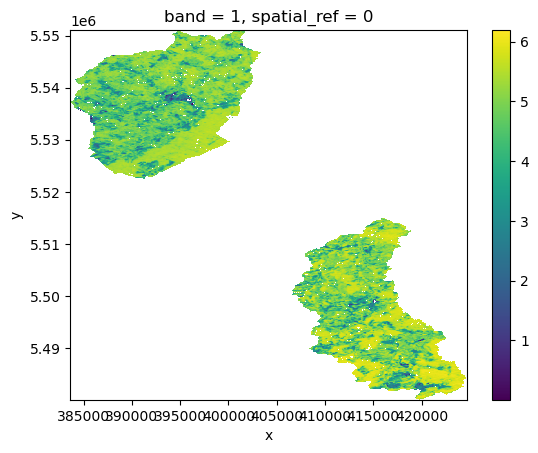

In [9]:
eta_day.plot()

### Import CORINE Land Cover Map

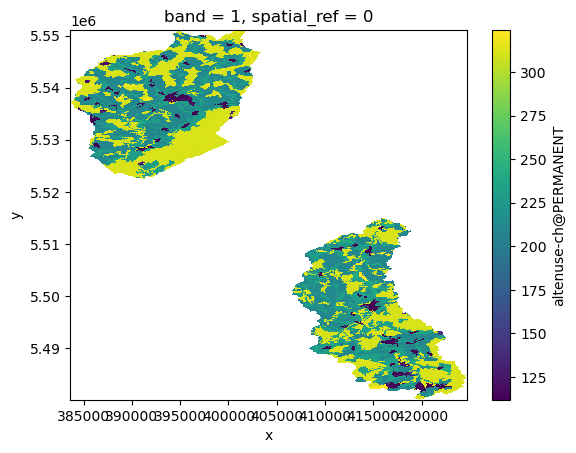

In [10]:
# Open Corine Land Use Maps for both catchments
path_LUA = path_data + "Original/study_area/altenuse-ch.tif"
LU_alten = rxr.open_rasterio(path_LUA).squeeze()


path_LUK = path_data + "Original/study_area/kelleuse-ch.tif"
LU_kellen = rxr.open_rasterio(path_LUK).squeeze()

# Merge raster
LU_mosaic = merge_arrays(dataarrays = [LU_alten, LU_kellen], nodata = np.nan)
#LU_mosaic = LU_mosaic .rename({"x": "long", "y": "lat"})
LU_mosaic.rio.write_crs("epsg:32632", inplace=True)

# Reproject and Resample Land Use Raster

# Using reproject_match https://corteva.github.io/rioxarray/html/examples/reproject_match.html
xds_match = eta_day
xds = LU_mosaic
xds_repr_match = xds.rio.reproject_match(xds_match)

xds_repr_match = xds_repr_match.assign_coords({
    "x": xds_match.x,
    "y": xds_match.y,
})

LU_mosaic = xds_repr_match

LU_mosaic.plot()


In [11]:
print(np.unique(LU_mosaic))
print(len(np.unique(LU_mosaic)))

[112. 121. 131. 132. 142. 211. 221. 231. 242. 243. 311. 312. 313. 322.
 324.  nan]
16


In [12]:
# Combine with Land Cover Key Table
LU_table_path = "../../data/clc_legend.csv"
LU_table = pd.read_csv(LU_table_path) #delimiter = "\t", header = [3]
#print(LU_table)

LU_agri = [211, 212, 221, 222, 223, 241, 242, 243, 244]
LU_bare = [331, 332, 333, 334, 131]
LU_grass = [231, 321, 322, 323, 324, 411, 412]
LU_urban = [111, 112, 121, 122, 123, 124, 132, 133, 141, 142]
LU_forest = [311, 312, 313]
LU_water = [511, 512, 335]

# Create filters from Land Use classes
agri_filter = np.isin(LU_mosaic.values, LU_agri)
bare_filter = np.isin(LU_mosaic.values, LU_bare)
grass_filter = np.isin(LU_mosaic.values, LU_grass)
urban_filter = np.isin(LU_mosaic.values, LU_urban)
forest_filter = np.isin(LU_mosaic.values, LU_forest)
water_filter = np.isin(LU_mosaic.values, LU_water)

### Results Lists

In [13]:
# Full regression
WASIM_fullreg = []
SSEB_fullreg = []
EEFlux_fullreg = []

# Agri
WASIM_agri = []
SSEB_agri = []
EEFlux_agri = []

# Bare Soil
WASIM_bare = []
SSEB_bare = []
EEFlux_bare = []

# Grass
WASIM_grass = []
SSEB_grass = []
EEFlux_grass = []

# Urban
WASIM_urban = []
SSEB_urban = []
EEFlux_urban = []

# Forest
WASIM_forest = []
SSEB_forest = []
EEFlux_forest = []

# WASIM ETa Raster

### Load data

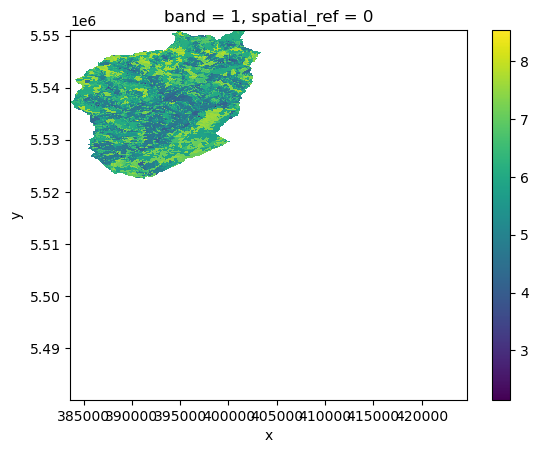

In [14]:
# Open WASIM Raster
path_wasim_kelle = path_data + "Original/WASIM_raster/etr_kelle_" + date_SSEB + ".tif"
wasim_kelle = rxr.open_rasterio(path_wasim_kelle, masked = True).squeeze()

# Merge raster
#LU_mosaic = merge_arrays(dataarrays = [LU_alten, LU_kellen], nodata = np.nan)
#LU_mosaic = LU_mosaic .rename({"x": "long", "y": "lat"})
wasim = wasim_kelle # + merged wasim altenbamberg
wasim.rio.write_crs("epsg:32632", inplace=True)

# Reproject and Resample Land Use Raster

# Using reproject_match https://corteva.github.io/rioxarray/html/examples/reproject_match.html
xds_match = eta_day
xds = wasim
xds_repr_match = xds.rio.reproject_match(xds_match)

xds_repr_match = xds_repr_match.assign_coords({
    "x": xds_match.x,
    "y": xds_match.y,
})

wasim = xds_repr_match

wasim.plot()

### Scatterplot, simple statistics

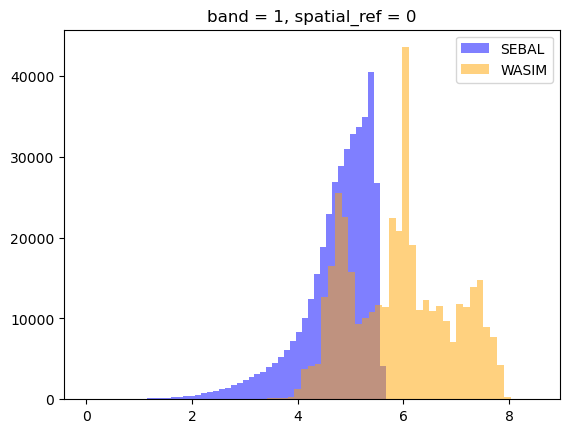

In [15]:
eta_kelle = eta_day.rio.clip(shape_kellen.geometry, all_touched = True)

eta_kelle.plot.hist(bins = 50, alpha = 0.5, color = "blue", label = "SEBAL")
wasim.plot.hist(bins = 50, alpha = 0.5, color = "orange", label = "WASIM")
plt.legend(loc='upper right')
plt.show()

Slope: 0.6424412001426386
Intercept: 2.8785455070537713
R-squared value: 0.22017127587560742
P-value: 0.0
Standard error: 0.0019172545969918045


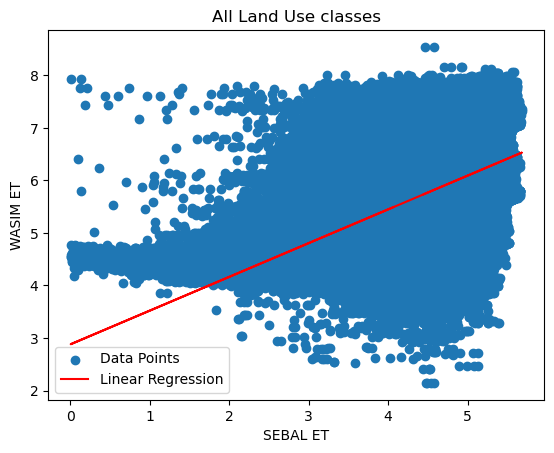

In [16]:
### Define Datasets 
title = "All Land Use classes"
x_name = "SEBAL ET"
y_name = "WASIM ET"

x_values = eta_day.values
y_values = wasim.values

# Remove NaN values
mask = ~np.isnan(x_values) & ~np.isnan(y_values)
x_values = x_values[mask]
y_values = y_values[mask]



### Linear Regression and Coefficients 
slope, intercept, r_value, p_value, std_err = linregress(x_values, y_values)

print(f"Slope: {slope}")
print(f"Intercept: {intercept}")
print(f"R-squared value: {r_value**2}")
print(f"P-value: {p_value}")
print(f"Standard error: {std_err}")


### Plot Regression
plt.scatter(x_values, y_values, label='Data Points')

# Plot the regression line
regression_line = slope * x_values + intercept
plt.plot(x_values, regression_line, color='red', label='Linear Regression')

# Labeling the plot
plt.xlabel(x_name)
plt.ylabel(y_name)
plt.title(title)
plt.legend()


# Show the plot
plt.show()

# Append results to list
WASIM_fullreg.extend((slope, intercept, r_value**2, p_value, std_err))



### Statistics grouped by Land Use

https://earth-env-data-science.github.io/lectures/xarray/xarray-part2.html

Slope: 0.13838653829672173
Intercept: 4.7554657331289105
R-squared value: 0.007482348842508548
P-value: 2.648479622853777e-234
Standard error: 0.00422613926202826


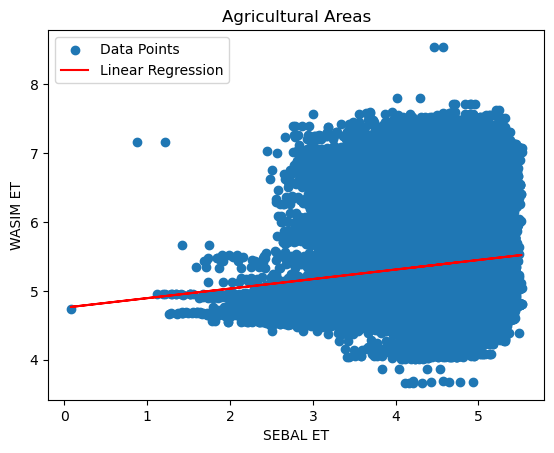

In [17]:
### Define Datasets 
title = "Agricultural Areas"
x_name = "SEBAL ET"
y_name = "WASIM ET"

x_values = eta_day.where(agri_filter).values
y_values = wasim.where(agri_filter).values

# Remove NaN values
mask = ~np.isnan(x_values) & ~np.isnan(y_values)
x_values = x_values[mask]
y_values = y_values[mask]



### Linear Regression and Coefficients 
slope, intercept, r_value, p_value, std_err = linregress(x_values, y_values)

print(f"Slope: {slope}")
print(f"Intercept: {intercept}")
print(f"R-squared value: {r_value**2}")
print(f"P-value: {p_value}")
print(f"Standard error: {std_err}")


### Plot Regression
plt.scatter(x_values, y_values, label='Data Points')

# Plot the regression line
regression_line = slope * x_values + intercept
plt.plot(x_values, regression_line, color='red', label='Linear Regression')

# Labeling the plot
plt.xlabel(x_name)
plt.ylabel(y_name)
plt.title(title)
plt.legend()

# Show the plot
plt.show()

# Results to list
WASIM_agri.extend((slope, intercept, r_value**2, p_value, std_err))

Slope: 0.12103070497069424
Intercept: 5.107719326893356
R-squared value: 0.012307264186163054
P-value: 1.0824915701021521e-209
Standard error: 0.003904316682749763


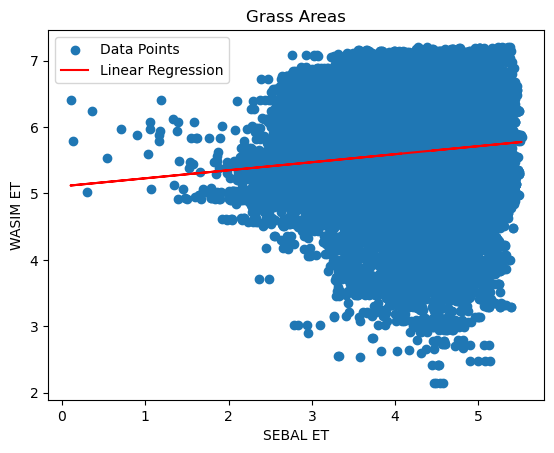

In [18]:
### Define Datasets 
title = "Grass Areas"
x_name = "SEBAL ET"
y_name = "WASIM ET"

x_values = eta_day.where(grass_filter).values
y_values = wasim.where(grass_filter).values

# Remove NaN values
mask = ~np.isnan(x_values) & ~np.isnan(y_values)
x_values = x_values[mask]
y_values = y_values[mask]



### Linear Regression and Coefficients 
slope, intercept, r_value, p_value, std_err = linregress(x_values, y_values)

print(f"Slope: {slope}")
print(f"Intercept: {intercept}")
print(f"R-squared value: {r_value**2}")
print(f"P-value: {p_value}")
print(f"Standard error: {std_err}")


### Plot Regression
plt.scatter(x_values, y_values, label='Data Points')

# Plot the regression line
regression_line = slope * x_values + intercept
plt.plot(x_values, regression_line, color='red', label='Linear Regression')

# Labeling the plot
plt.xlabel(x_name)
plt.ylabel(y_name)
plt.title(title)
plt.legend()

# Show the plot
plt.show()

# Results to list
WASIM_grass.extend((slope, intercept, r_value**2, p_value, std_err))

Slope: 0.021472569966724076
Intercept: 6.562615191625152
R-squared value: 0.00011705420981767243
P-value: 1.353870361459158e-05
Standard error: 0.0049346959241631455


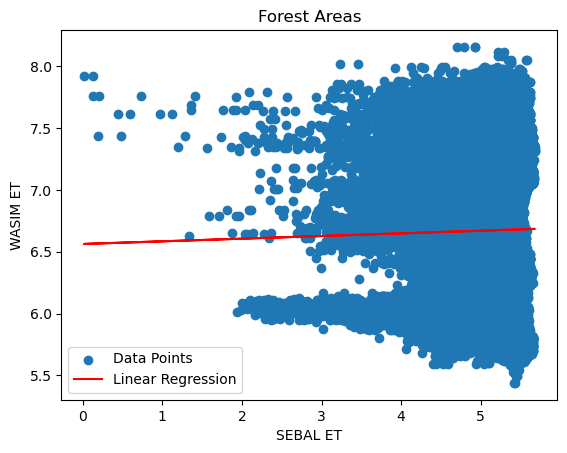

In [19]:
### Define Datasets 
title = "Forest Areas"
x_name = "SEBAL ET"
y_name = "WASIM ET"

x_values = eta_day.where(forest_filter).values
y_values = wasim.where(forest_filter).values

# Remove NaN values
mask = ~np.isnan(x_values) & ~np.isnan(y_values)
x_values = x_values[mask]
y_values = y_values[mask]



### Linear Regression and Coefficients 
slope, intercept, r_value, p_value, std_err = linregress(x_values, y_values)

print(f"Slope: {slope}")
print(f"Intercept: {intercept}")
print(f"R-squared value: {r_value**2}")
print(f"P-value: {p_value}")
print(f"Standard error: {std_err}")


### Plot Regression
plt.scatter(x_values, y_values, label='Data Points')

# Plot the regression line
regression_line = slope * x_values + intercept
plt.plot(x_values, regression_line, color='red', label='Linear Regression')

# Labeling the plot
plt.xlabel(x_name)
plt.ylabel(y_name)
plt.title(title)
plt.legend()

# Show the plot
plt.show()

# Results to list
WASIM_forest.extend((slope, intercept, r_value**2, p_value, std_err))

Slope: 0.03304209876632728
Intercept: 3.998237880863729
R-squared value: 0.018190550666066032
P-value: 0.0008559508456545395
Standard error: 0.009861023496140382


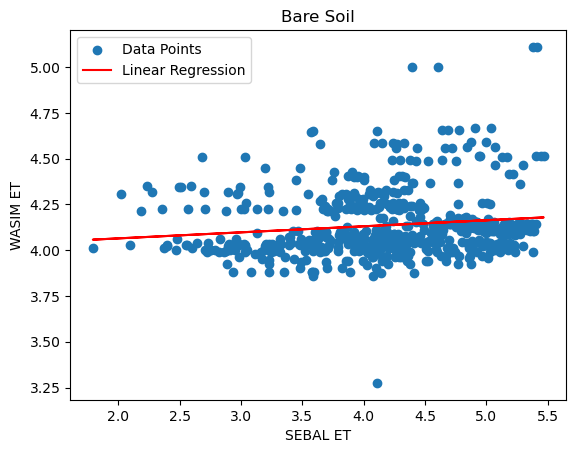

In [20]:
### Define Datasets 
title = "Bare Soil"
x_name = "SEBAL ET"
y_name = "WASIM ET"

x_values = eta_day.where(bare_filter).values
y_values = wasim.where(bare_filter).values

# Remove NaN values
mask = ~np.isnan(x_values) & ~np.isnan(y_values)
x_values = x_values[mask]
y_values = y_values[mask]



### Linear Regression and Coefficients 
slope, intercept, r_value, p_value, std_err = linregress(x_values, y_values)

print(f"Slope: {slope}")
print(f"Intercept: {intercept}")
print(f"R-squared value: {r_value**2}")
print(f"P-value: {p_value}")
print(f"Standard error: {std_err}")


### Plot Regression
plt.scatter(x_values, y_values, label='Data Points')

# Plot the regression line
regression_line = slope * x_values + intercept
plt.plot(x_values, regression_line, color='red', label='Linear Regression')

# Labeling the plot
plt.xlabel(x_name)
plt.ylabel(y_name)
plt.title(title)
plt.legend()

# Show the plot
plt.show()

# Results to list
WASIM_bare.extend((slope, intercept, r_value**2, p_value, std_err))

Slope: -0.020903467563860873
Intercept: 4.431198383667319
R-squared value: 0.004272443139647186
P-value: 1.3000259466130897e-16
Standard error: 0.002523790972149745


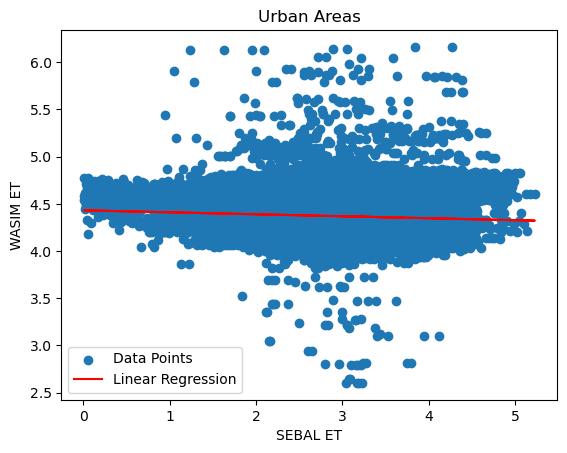

In [21]:
### Define Datasets 
title = "Urban Areas"
x_name = "SEBAL ET"
y_name = "WASIM ET"

x_values = eta_day.where(urban_filter).values
y_values = wasim.where(urban_filter).values

# Remove NaN values
mask = ~np.isnan(x_values) & ~np.isnan(y_values)
x_values = x_values[mask]
y_values = y_values[mask]



### Linear Regression and Coefficients 
slope, intercept, r_value, p_value, std_err = linregress(x_values, y_values)

print(f"Slope: {slope}")
print(f"Intercept: {intercept}")
print(f"R-squared value: {r_value**2}")
print(f"P-value: {p_value}")
print(f"Standard error: {std_err}")


### Plot Regression
plt.scatter(x_values, y_values, label='Data Points')

# Plot the regression line
regression_line = slope * x_values + intercept
plt.plot(x_values, regression_line, color='red', label='Linear Regression')

# Labeling the plot
plt.xlabel(x_name)
plt.ylabel(y_name)
plt.title(title)
plt.legend()

# Show the plot
plt.show()

# Results to list
WASIM_urban.extend((slope, intercept, r_value**2, p_value, std_err))

### SPAEF WASIM

In [22]:
SPAEF(wasim.values, eta_day.values)

(0.1690005259869335,
 0.46922412115705164,
 1.0947494902649875,
 0.36765545282416334)

# SSEB Raster

### Load data

['D:/Nicolas_D/Geodaten/Masterarbeit/DATA_MesoHyd_MA-SEBAL/Original/SSEB\\Landsat8_MesoHyd_2019_06_29_ETa_SSEB_Alten_v2.tif', 'D:/Nicolas_D/Geodaten/Masterarbeit/DATA_MesoHyd_MA-SEBAL/Original/SSEB\\Landsat8_MesoHyd_2019_06_29_ETa_SSEB_Kellen_v2.tif']


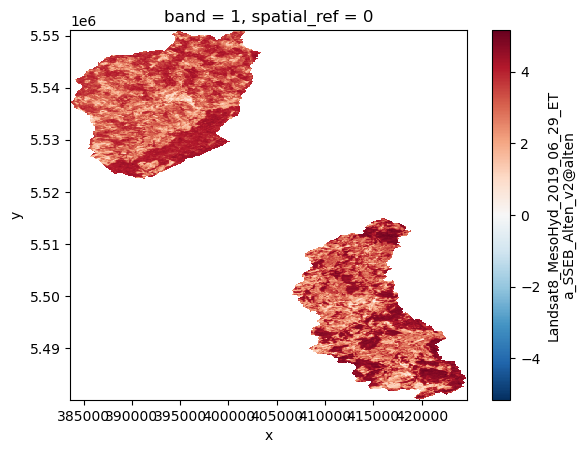

In [23]:
# DATA FROM SSEB

# Date in SSEB-Raster Path Format with time (hour)

# Create Path for recursive file search based on defined date
path_SSEB = path_data + "Original/SSEB/"
pattern = f"*{date_SSEB}*.tif"
paths_SSEB = sorted(glob.glob(os.path.join(path_SSEB, "**", pattern), recursive=True))
print(paths_SSEB)

# Combine both Rasters
raster_0 = rxr.open_rasterio(paths_SSEB[0]).squeeze()
raster_1 = rxr.open_rasterio(paths_SSEB[1]).squeeze()
SSEB_raster = merge_arrays(dataarrays = [raster_0, raster_1], nodata = np.nan)
SSEB_raster.rio.write_crs("epsg:32632", inplace=True)

# Using reproject_match https://corteva.github.io/rioxarray/html/examples/reproject_match.html
xds_match = eta_day
xds = SSEB_raster
xds_repr_match = xds.rio.reproject_match(xds_match)

xds_repr_match = xds_repr_match.assign_coords({
    "x": xds_match.x,
    "y": xds_match.y,
})

SSEB_raster = xds_repr_match

SSEB_raster.plot()

### Scatterplot, simple statistics

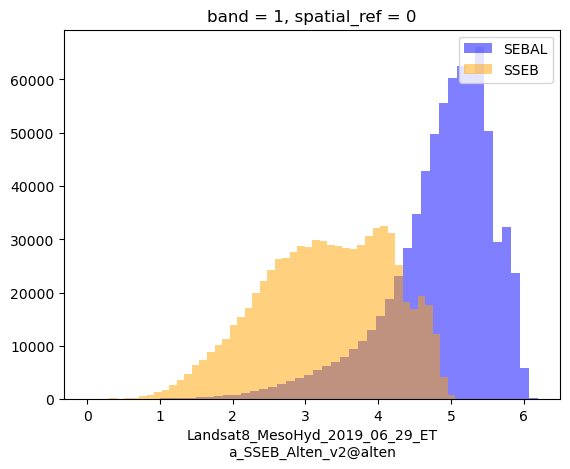

In [24]:
eta_day.plot.hist(bins = 50, alpha = 0.5, color = "blue", label = "SEBAL")
SSEB_raster.plot.hist(bins = 50, alpha = 0.5, color = "orange", label = "SSEB")
plt.legend(loc='upper right')
plt.show()

Slope: 1.0581873478682784
Intercept: -1.8531590209675524
R-squared value: 0.8074407971303891
P-value: 0.0
Standard error: 0.0005979803519173516


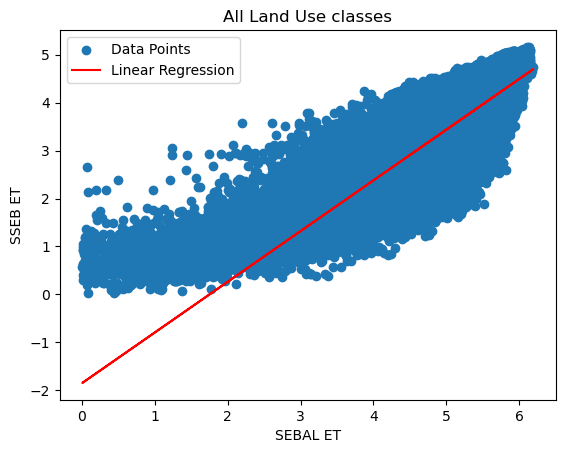

In [25]:
### Define Datasets 
title = "All Land Use classes"
x_name = "SEBAL ET"
y_name = "SSEB ET"

x_values = eta_day.values
y_values = SSEB_raster.values

# Remove NaN values
mask = ~np.isnan(x_values) & ~np.isnan(y_values)
x_values = x_values[mask]
y_values = y_values[mask]



### Linear Regression and Coefficients 
slope, intercept, r_value, p_value, std_err = linregress(x_values, y_values)

print(f"Slope: {slope}")
print(f"Intercept: {intercept}")
print(f"R-squared value: {r_value**2}")
print(f"P-value: {p_value}")
print(f"Standard error: {std_err}")


### Plot Regression
plt.scatter(x_values, y_values, label='Data Points')

# Plot the regression line
regression_line = slope * x_values + intercept
plt.plot(x_values, regression_line, color='red', label='Linear Regression')

# Labeling the plot
plt.xlabel(x_name)
plt.ylabel(y_name)
plt.title(title)
plt.legend()


# Show the plot
plt.show()

# Results into List
SSEB_fullreg.extend((slope, intercept, r_value**2, p_value, std_err))

Slope: 0.9637584691789981
Intercept: -1.6584172668101247
R-squared value: 0.7257908939869729
P-value: 0.0
Standard error: 0.0011556255857199833


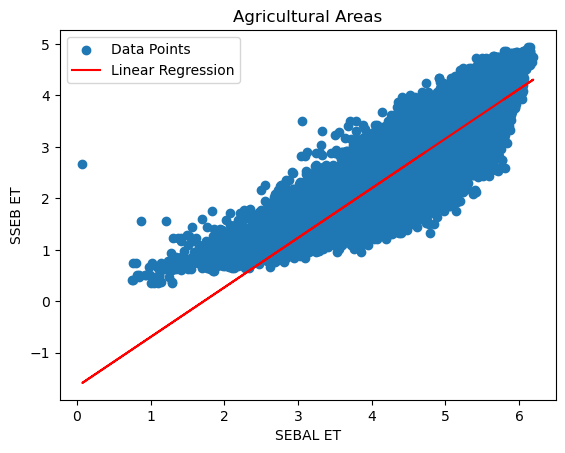

In [26]:
### Define Datasets 
title = "Agricultural Areas"
x_name = "SEBAL ET"
y_name = "SSEB ET"

x_values = eta_day.where(agri_filter).values
y_values = SSEB_raster.where(agri_filter).values

# Remove NaN values
mask = ~np.isnan(x_values) & ~np.isnan(y_values)
x_values = x_values[mask]
y_values = y_values[mask]



### Linear Regression and Coefficients 
slope, intercept, r_value, p_value, std_err = linregress(x_values, y_values)

print(f"Slope: {slope}")
print(f"Intercept: {intercept}")
print(f"R-squared value: {r_value**2}")
print(f"P-value: {p_value}")
print(f"Standard error: {std_err}")


### Plot Regression
plt.scatter(x_values, y_values, label='Data Points')

# Plot the regression line
regression_line = slope * x_values + intercept
plt.plot(x_values, regression_line, color='red', label='Linear Regression')

# Labeling the plot
plt.xlabel(x_name)
plt.ylabel(y_name)
plt.title(title)
plt.legend()

# Show the plot
plt.show()

# Results into List
SSEB_agri.extend((slope, intercept, r_value**2, p_value, std_err))

Slope: 0.9426644326051757
Intercept: -1.4691906255235692
R-squared value: 0.7998887201812419
P-value: 0.0
Standard error: 0.0011405076277637986


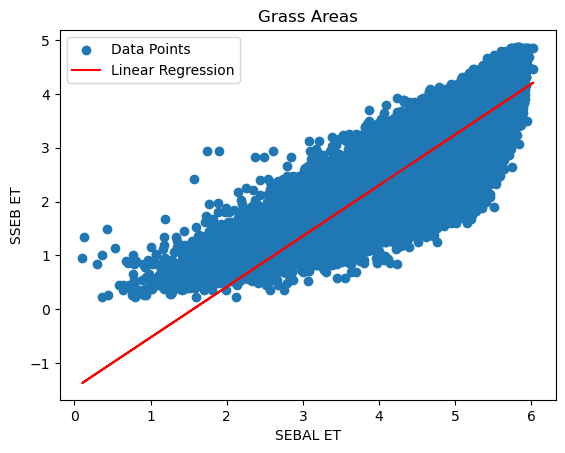

In [27]:
### Define Datasets 
title = "Grass Areas"
x_name = "SEBAL ET"
y_name = "SSEB ET"

x_values = eta_day.where(grass_filter).values
y_values = SSEB_raster.where(grass_filter).values

# Remove NaN values
mask = ~np.isnan(x_values) & ~np.isnan(y_values)
x_values = x_values[mask]
y_values = y_values[mask]



### Linear Regression and Coefficients 
slope, intercept, r_value, p_value, std_err = linregress(x_values, y_values)

print(f"Slope: {slope}")
print(f"Intercept: {intercept}")
print(f"R-squared value: {r_value**2}")
print(f"P-value: {p_value}")
print(f"Standard error: {std_err}")


### Plot Regression
plt.scatter(x_values, y_values, label='Data Points')

# Plot the regression line
regression_line = slope * x_values + intercept
plt.plot(x_values, regression_line, color='red', label='Linear Regression')

# Labeling the plot
plt.xlabel(x_name)
plt.ylabel(y_name)
plt.title(title)
plt.legend()

# Show the plot
plt.show()

# Results into List
SSEB_grass.extend((slope, intercept, r_value**2, p_value, std_err))

Slope: 1.0112285117619781
Intercept: -1.3230345021632512
R-squared value: 0.8103226744561521
P-value: 0.0
Standard error: 0.0009284105762779358


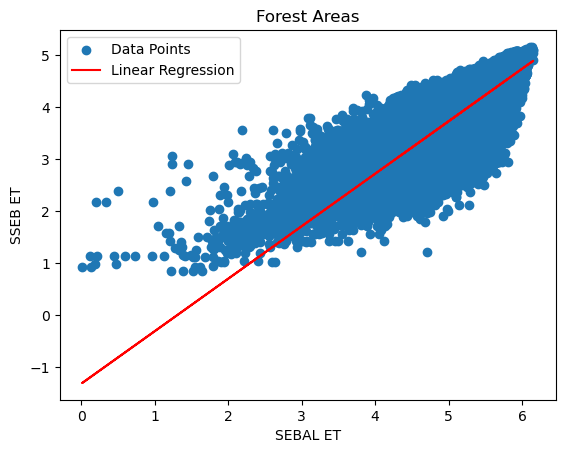

In [28]:
### Define Datasets 
title = "Forest Areas"
x_name = "SEBAL ET"
y_name = "SSEB ET"

x_values = eta_day.where(forest_filter).values
y_values = SSEB_raster.where(forest_filter).values

# Remove NaN values
mask = ~np.isnan(x_values) & ~np.isnan(y_values)
x_values = x_values[mask]
y_values = y_values[mask]



### Linear Regression and Coefficients 
slope, intercept, r_value, p_value, std_err = linregress(x_values, y_values)

print(f"Slope: {slope}")
print(f"Intercept: {intercept}")
print(f"R-squared value: {r_value**2}")
print(f"P-value: {p_value}")
print(f"Standard error: {std_err}")


### Plot Regression
plt.scatter(x_values, y_values, label='Data Points')

# Plot the regression line
regression_line = slope * x_values + intercept
plt.plot(x_values, regression_line, color='red', label='Linear Regression')

# Labeling the plot
plt.xlabel(x_name)
plt.ylabel(y_name)
plt.title(title)
plt.legend()

# Show the plot
plt.show()

# Results into List
SSEB_forest.extend((slope, intercept, r_value**2, p_value, std_err))

Slope: 0.588858400653531
Intercept: -0.33084469877872724
R-squared value: 0.6376140703528277
P-value: 1.0883101675371893e-135
Standard error: 0.01803355216343415


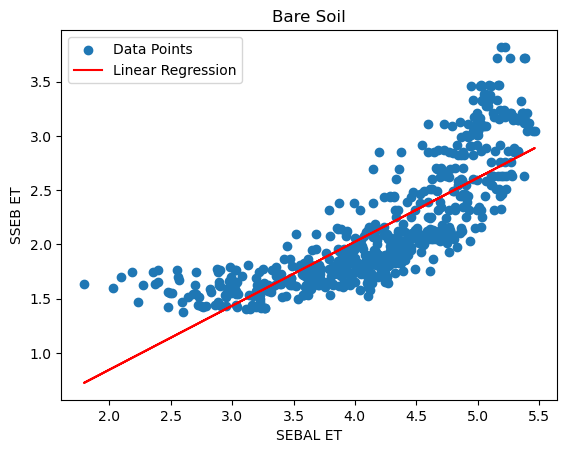

In [29]:
### Define Datasets 
title = "Bare Soil"
x_name = "SEBAL ET"
y_name = "SSEB ET"

x_values = eta_day.where(bare_filter).values
y_values = SSEB_raster.where(bare_filter).values

# Remove NaN values
mask = ~np.isnan(x_values) & ~np.isnan(y_values)
x_values = x_values[mask]
y_values = y_values[mask]



### Linear Regression and Coefficients 
slope, intercept, r_value, p_value, std_err = linregress(x_values, y_values)

print(f"Slope: {slope}")
print(f"Intercept: {intercept}")
print(f"R-squared value: {r_value**2}")
print(f"P-value: {p_value}")
print(f"Standard error: {std_err}")


### Plot Regression
plt.scatter(x_values, y_values, label='Data Points')

# Plot the regression line
regression_line = slope * x_values + intercept
plt.plot(x_values, regression_line, color='red', label='Linear Regression')

# Labeling the plot
plt.xlabel(x_name)
plt.ylabel(y_name)
plt.title(title)
plt.legend()

# Show the plot
plt.show()

# Results into List
SSEB_bare.extend((slope, intercept, r_value**2, p_value, std_err))

Slope: 0.5864080436285315
Intercept: 0.007115223443713292
R-squared value: 0.7483320102786649
P-value: 0.0
Standard error: 0.001822645719630043


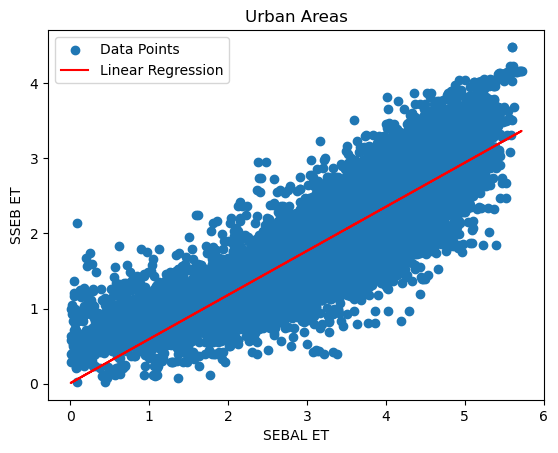

In [30]:
### Define Datasets 
title = "Urban Areas"
x_name = "SEBAL ET"
y_name = "SSEB ET"

x_values = eta_day.where(urban_filter).values
y_values = SSEB_raster.where(urban_filter).values

# Remove NaN values
mask = ~np.isnan(x_values) & ~np.isnan(y_values)
x_values = x_values[mask]
y_values = y_values[mask]



### Linear Regression and Coefficients 
slope, intercept, r_value, p_value, std_err = linregress(x_values, y_values)

print(f"Slope: {slope}")
print(f"Intercept: {intercept}")
print(f"R-squared value: {r_value**2}")
print(f"P-value: {p_value}")
print(f"Standard error: {std_err}")


### Plot Regression
plt.scatter(x_values, y_values, label='Data Points')

# Plot the regression line
regression_line = slope * x_values + intercept
plt.plot(x_values, regression_line, color='red', label='Linear Regression')

# Labeling the plot
plt.xlabel(x_name)
plt.ylabel(y_name)
plt.title(title)
plt.legend()

# Show the plot
plt.show()

# Results into List
SSEB_urban.extend((slope, intercept, r_value**2, p_value, std_err))

Slope: 0.7055655730590226
Intercept: 3.652959455838549
R-squared value: 0.32285294833732736
P-value: 0.0
Standard error: 0.0016121003445858685


c:\Users\nicol\anaconda3\envs\ET_master_project\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\nicol\anaconda3\envs\ET_master_project\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\nicol\anaconda3\envs\ET_master_project\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\nicol\anaconda3\envs\ET_master_project\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\nicol\anaconda3\envs\ET_master_project\Lib\site-packages\IPython\core\pylabtools.py:152: Us

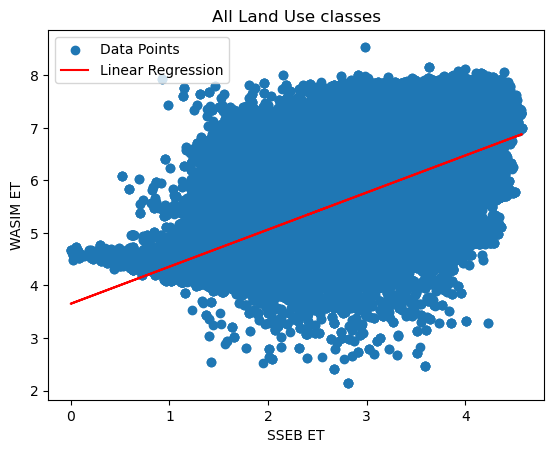

In [31]:
# WASIM AND SSEB
### Define Datasets 
title = "All Land Use classes"
x_name = "SSEB ET"
y_name = "WASIM ET"

x_values = SSEB_raster.values
y_values = wasim.values

# Remove NaN values
mask = ~np.isnan(x_values) & ~np.isnan(y_values)
x_values = x_values[mask]
y_values = y_values[mask]



### Linear Regression and Coefficients 
slope, intercept, r_value, p_value, std_err = linregress(x_values, y_values)

print(f"Slope: {slope}")
print(f"Intercept: {intercept}")
print(f"R-squared value: {r_value**2}")
print(f"P-value: {p_value}")
print(f"Standard error: {std_err}")


### Plot Regression
plt.scatter(x_values, y_values, label='Data Points')

# Plot the regression line
regression_line = slope * x_values + intercept
plt.plot(x_values, regression_line, color='red', label='Linear Regression')

# Labeling the plot
plt.xlabel(x_name)
plt.ylabel(y_name)
plt.title(title)
plt.legend()


# Show the plot
plt.show()

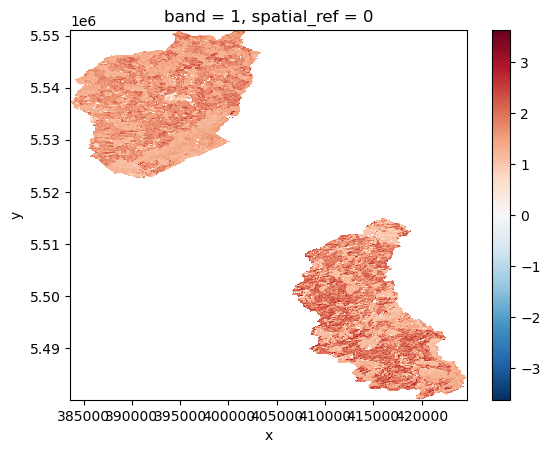

In [32]:
# Difference raster
diff = eta_day - SSEB_raster
diff.plot()

### SPAEF SSEB

In [33]:
SPAEF(eta_day.values, SSEB_raster.values)

(0.39318478367100906,
 0.8985770958189335,
 0.5738251623971988,
 0.5801034543246345)

In [34]:
SPAEF(SSEB_raster.values, eta_day.values)

(0.1408202891066519,
 0.8985770958189334,
 1.7426910939604372,
 0.5801034543246345)

# EEFlux Raster

### Load data

In [35]:
# DATA FROM EEFlux

# Date in EEflux-Raster Path Format with time (hour)
date_eeflux = date_SSEB

# Create Path for recursive file search based on defined date
path_dir = path_data + "Original/EEFlux/"
pattern = f"*{date_eeflux}*.tif"
path_eeflux = sorted(glob.glob(os.path.join(path_dir, "**", pattern), recursive=True))
print(path_eeflux)

# Combine both Rasters
eeflux = rxr.open_rasterio(path_eeflux[0]).squeeze()
eeflux .rio.write_crs("epsg:32632", inplace=True)

# Clip raster by catchment vectors
eeflux_clip = eeflux.rio.clip(shape_catchments.geometry, all_touched = True)

# Resample rad raster big to same resolution (30x30m)
# Using reproject_match https://corteva.github.io/rioxarray/html/examples/reproject_match.html
xds_match = eta_day
xds = eeflux_clip
xds_repr_match = xds.rio.reproject_match(xds_match)

xds_repr_match = xds_repr_match.assign_coords({
    "x": xds_match.x,
    "y": xds_match.y,
})

eeflux = xds_repr_match

['D:/Nicolas_D/Geodaten/Masterarbeit/DATA_MesoHyd_MA-SEBAL/Original/EEFlux\\eeflux_2019_06_29.tif']


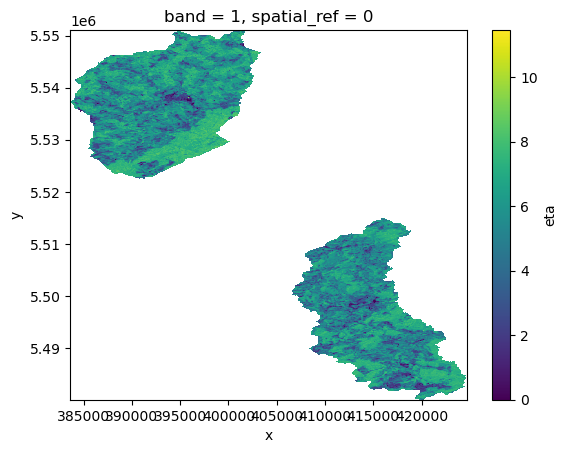

In [36]:
eeflux.plot()

### Scatterplot, simple statistics

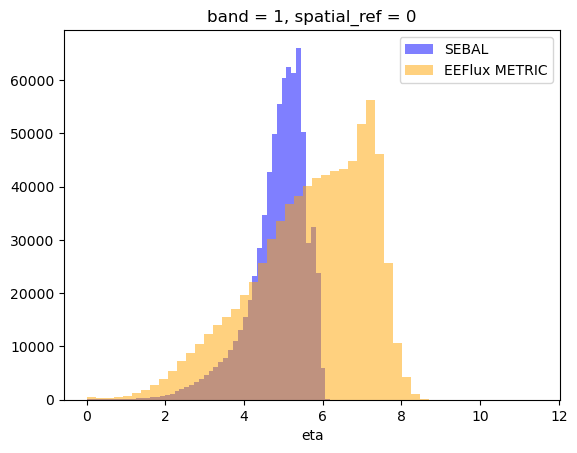

In [37]:
eta_day.plot.hist(bins = 50, alpha = 0.5, color = "blue", label = "SEBAL")
eeflux.plot.hist(bins = 50, alpha = 0.5, color = "orange", label = "EEFlux METRIC")
plt.legend(loc='upper right')
plt.show()

Slope: 1.765064740023126
Intercept: -2.8781014334223842
R-squared value: 0.7979522022541664
P-value: 0.0
Standard error: 0.0010277720799480889


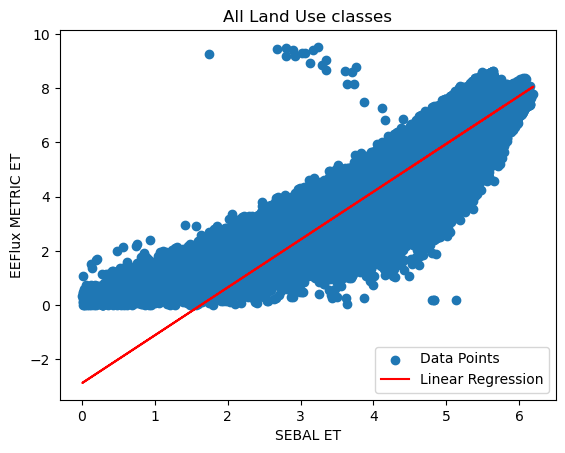

In [38]:
### Define Datasets 

title = "All Land Use classes"
x_name = "SEBAL ET"
y_name = "EEFlux METRIC ET"

x_values = eta_day.values
y_values = eeflux.values

# Remove NaN values
mask = ~np.isnan(x_values) & ~np.isnan(y_values)
x_values = x_values[mask]
y_values = y_values[mask]



### Linear Regression and Coefficients 
slope, intercept, r_value, p_value, std_err = linregress(x_values, y_values)

print(f"Slope: {slope}")
print(f"Intercept: {intercept}")
print(f"R-squared value: {r_value**2}")
print(f"P-value: {p_value}")
print(f"Standard error: {std_err}")


### Plot Regression
plt.scatter(x_values, y_values, label='Data Points')

# Plot the regression line
regression_line = slope * x_values + intercept
plt.plot(x_values, regression_line, color='red', label='Linear Regression')

# Labeling the plot
plt.xlabel(x_name)
plt.ylabel(y_name)
plt.title(title)
plt.legend()

# Show the plot
plt.show()

# Results in List
EEFlux_fullreg.extend((slope, intercept, r_value**2, p_value, std_err))


Slope: 1.6171738555830448
Intercept: -2.3507127369845673
R-squared value: 0.666503859998145
P-value: 0.0
Standard error: 0.002231590711886215


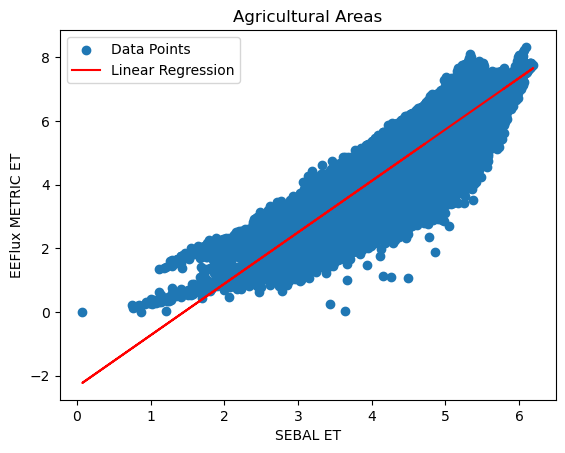

In [39]:
### Define Datasets 
title = "Agricultural Areas"
x_name = "SEBAL ET"
y_name = "EEFlux METRIC ET"

x_values = eta_day.where(agri_filter).values
y_values = eeflux.where(agri_filter).values

# Remove NaN values
mask = ~np.isnan(x_values) & ~np.isnan(y_values)
x_values = x_values[mask]
y_values = y_values[mask]



### Linear Regression and Coefficients 
slope, intercept, r_value, p_value, std_err = linregress(x_values, y_values)

print(f"Slope: {slope}")
print(f"Intercept: {intercept}")
print(f"R-squared value: {r_value**2}")
print(f"P-value: {p_value}")
print(f"Standard error: {std_err}")


### Plot Regression
plt.scatter(x_values, y_values, label='Data Points')

# Plot the regression line
regression_line = slope * x_values + intercept
plt.plot(x_values, regression_line, color='red', label='Linear Regression')

# Labeling the plot
plt.xlabel(x_name)
plt.ylabel(y_name)
plt.title(title)
plt.legend()

# Show the plot
plt.show()

# Results into List
EEFlux_agri.extend((slope, intercept, r_value**2, p_value, std_err))

Slope: 1.574957991672572
Intercept: -2.414163974578523
R-squared value: 0.7854372513538723
P-value: 0.0
Standard error: 0.001991179734795799


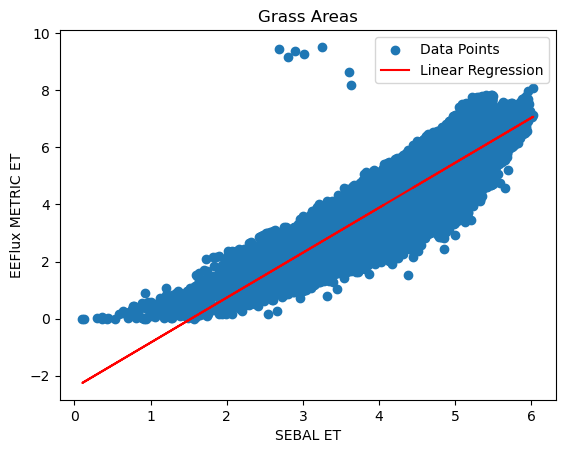

In [40]:
### Define Datasets 
title = "Grass Areas"
x_name = "SEBAL ET"
y_name = "EEFlux METRIC ET"

x_values = eta_day.where(grass_filter).values
y_values = eeflux.where(grass_filter).values

# Remove NaN values
mask = ~np.isnan(x_values) & ~np.isnan(y_values)
x_values = x_values[mask]
y_values = y_values[mask]



### Linear Regression and Coefficients 
slope, intercept, r_value, p_value, std_err = linregress(x_values, y_values)

print(f"Slope: {slope}")
print(f"Intercept: {intercept}")
print(f"R-squared value: {r_value**2}")
print(f"P-value: {p_value}")
print(f"Standard error: {std_err}")


### Plot Regression
plt.scatter(x_values, y_values, label='Data Points')

# Plot the regression line
regression_line = slope * x_values + intercept
plt.plot(x_values, regression_line, color='red', label='Linear Regression')

# Labeling the plot
plt.xlabel(x_name)
plt.ylabel(y_name)
plt.title(title)
plt.legend()

# Show the plot
plt.show()

# Results into List
EEFlux_grass.extend((slope, intercept, r_value**2, p_value, std_err))

Slope: 1.3432672511553492
Intercept: -0.243541280531395
R-squared value: 0.552792871806686
P-value: 0.0
Standard error: 0.002292702098302186


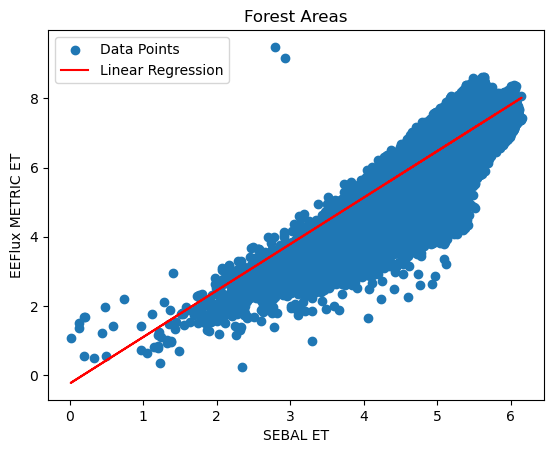

In [41]:
### Define Datasets 
title = "Forest Areas"
x_name = "SEBAL ET"
y_name = "EEFlux METRIC ET"

x_values = eta_day.where(forest_filter).values
y_values = eeflux.where(forest_filter).values

# Remove NaN values
mask = ~np.isnan(x_values) & ~np.isnan(y_values)
x_values = x_values[mask]
y_values = y_values[mask]



### Linear Regression and Coefficients 
slope, intercept, r_value, p_value, std_err = linregress(x_values, y_values)

print(f"Slope: {slope}")
print(f"Intercept: {intercept}")
print(f"R-squared value: {r_value**2}")
print(f"P-value: {p_value}")
print(f"Standard error: {std_err}")


### Plot Regression
plt.scatter(x_values, y_values, label='Data Points')

# Plot the regression line
regression_line = slope * x_values + intercept
plt.plot(x_values, regression_line, color='red', label='Linear Regression')

# Labeling the plot
plt.xlabel(x_name)
plt.ylabel(y_name)
plt.title(title)
plt.legend()

# Show the plot
plt.show()

# Results into List
EEFlux_forest.extend((slope, intercept, r_value**2, p_value, std_err))

Slope: 1.8429613963109799
Intercept: -4.7932215735563695
R-squared value: 0.602999679855679
P-value: 1.1311669130837357e-123
Standard error: 0.06074587805336591


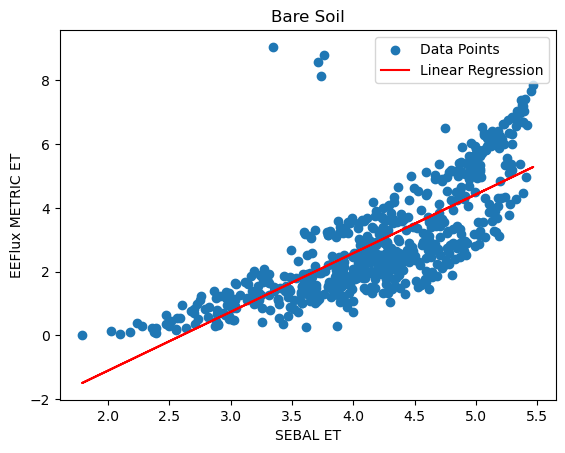

In [42]:
### Define Datasets 
title = "Bare Soil"
x_name = "SEBAL ET"
y_name = "EEFlux METRIC ET"

x_values = eta_day.where(bare_filter).values
y_values = eeflux.where(bare_filter).values

# Remove NaN values
mask = ~np.isnan(x_values) & ~np.isnan(y_values)
x_values = x_values[mask]
y_values = y_values[mask]



### Linear Regression and Coefficients 
slope, intercept, r_value, p_value, std_err = linregress(x_values, y_values)

print(f"Slope: {slope}")
print(f"Intercept: {intercept}")
print(f"R-squared value: {r_value**2}")
print(f"P-value: {p_value}")
print(f"Standard error: {std_err}")


### Plot Regression
plt.scatter(x_values, y_values, label='Data Points')

# Plot the regression line
regression_line = slope * x_values + intercept
plt.plot(x_values, regression_line, color='red', label='Linear Regression')

# Labeling the plot
plt.xlabel(x_name)
plt.ylabel(y_name)
plt.title(title)
plt.legend()

# Show the plot
plt.show()

# Results into List
EEFlux_bare.extend((slope, intercept, r_value**2, p_value, std_err))

Slope: 1.1105202021863414
Intercept: -0.541284830978813
R-squared value: 0.7828057878288225
P-value: 0.0
Standard error: 0.003135155498604711


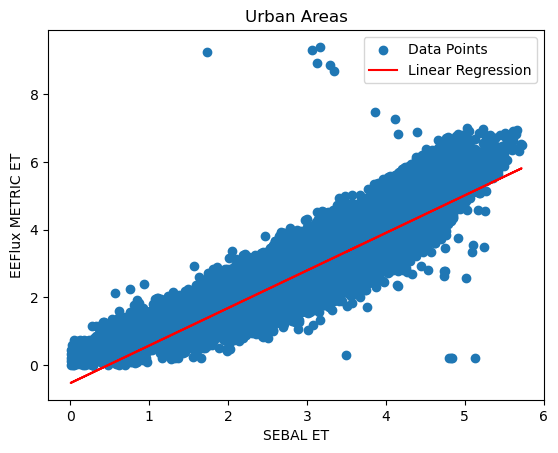

In [43]:
### Define Datasets 
title = "Urban Areas"
x_name = "SEBAL ET"
y_name = "EEFlux METRIC ET"

x_values = eta_day.where(urban_filter).values
y_values = eeflux.where(urban_filter).values

# Remove NaN values
mask = ~np.isnan(x_values) & ~np.isnan(y_values)
x_values = x_values[mask]
y_values = y_values[mask]



### Linear Regression and Coefficients 
slope, intercept, r_value, p_value, std_err = linregress(x_values, y_values)

print(f"Slope: {slope}")
print(f"Intercept: {intercept}")
print(f"R-squared value: {r_value**2}")
print(f"P-value: {p_value}")
print(f"Standard error: {std_err}")


### Plot Regression
plt.scatter(x_values, y_values, label='Data Points')

# Plot the regression line
regression_line = slope * x_values + intercept
plt.plot(x_values, regression_line, color='red', label='Linear Regression')

# Labeling the plot
plt.xlabel(x_name)
plt.ylabel(y_name)
plt.title(title)
plt.legend()

# Show the plot
plt.show()

# Results into List
EEFlux_urban.extend((slope, intercept, r_value**2, p_value, std_err))

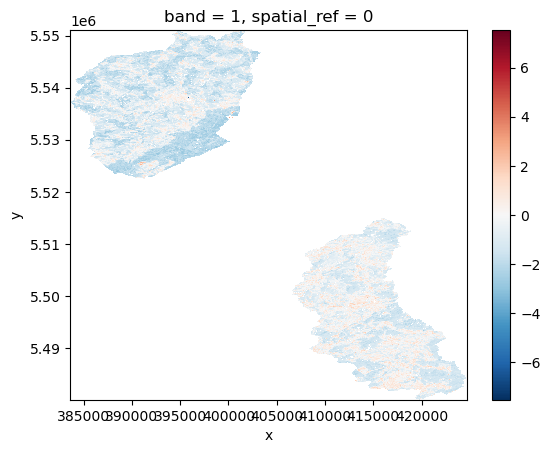

In [44]:
# Difference raster
diff = eta_day - eeflux
diff.plot()

### SPAEF EEFlux

In [45]:
SPAEF(eeflux.values, eta_day.values)

(0.13316891824761534,
 0.8932817037498116,
 1.6872289337946598,
 0.4825797432522365)

In [46]:
SPAEF(eta_day.values, eeflux.values)

(0.3329049936731433,
 0.8932817037498116,
 0.5926877971153277,
 0.4825797432522365)

# Regression Table

In [47]:
land_use_reg = [WASIM_agri, SSEB_agri, EEFlux_agri, 
                WASIM_bare, SSEB_bare, EEFlux_bare, 
                WASIM_grass, SSEB_grass, EEFlux_grass,
                WASIM_urban, SSEB_urban, EEFlux_urban,
                WASIM_forest, SSEB_forest, EEFlux_forest 
                ]



In [48]:
land_use_names = ["WASIM_agri", "SSEB_agri", "EEFlux_agri", 
                "WASIM_bare", "SSEB_bare", "EEFlux_bare", 
                "WASIM_grass", "SSEB_grass", "EEFlux_grass",
                "WASIM_urban", "SSEB_urban", "EEFlux_urban",
                "WASIM_forest", "SSEB_forest", "EEFlux_forest" 
                ]

modelnames = ["WASIM", "SSEB", "EEFlux"] * 5

land_use_class = ["Agriculture"]*3+["BareSoil"]*3+["Grass"]*3+["Urban"]*3+["Forest"]*3

In [49]:
parameters = ["slope", "intercept", "r_sqrd", "p_value", "std_err"]

full_regressions = pd.DataFrame({
    "Parameter": parameters,
    "WASIM": WASIM_fullreg,
    "SSEB": SSEB_fullreg})

full_regressions

,Parameter,WASIM,SSEB
0,slope,0.642441,1.058187
1,intercept,2.878546,-1.853159
2,r_sqrd,0.220171,0.807441
3,p_value,0.000000,0.000000
4,std_err,0.001917,0.000598


In [50]:
colnames = ["Model", "LandUse", "slope", "intercept", "r_sqrd", "p_value", "std_err"]

df = pd.DataFrame(columns=colnames)

list = []

for i in range(0,len(land_use_class)):
    list = [modelnames[i]]
    list.append(land_use_class[i])
    list.extend(land_use_reg[i])
    df.loc[i] = list
    
df

,Model,LandUse,slope,intercept,r_sqrd,p_value,std_err
0,WASIM,Agriculture,0.138387,4.755466,0.007482,2.648480e-234,0.004226
1,SSEB,Agriculture,0.963758,-1.658417,0.725791,0.000000e+00,0.001156
2,EEFlux,Agriculture,1.617174,-2.350713,0.666504,0.000000e+00,0.002232
3,WASIM,BareSoil,0.033042,3.998238,0.018191,8.559508e-04,0.009861
4,SSEB,BareSoil,0.588858,-0.330845,0.637614,1.088310e-135,0.018034
5,EEFlux,BareSoil,1.842961,-4.793222,0.603000,1.131167e-123,0.060746
6,WASIM,Grass,0.121031,5.107719,0.012307,1.082492e-209,0.003904
7,SSEB,Grass,0.942664,-1.469191,0.799889,0.000000e+00,0.001141
8,EEFlux,Grass,1.574958,-2.414164,0.785437,0.000000e+00,0.001991
9,WASIM,Urban,-0.020903,4.431198,0.004272,1.300026e-16,0.002524


<Axes: xlabel='LandUse', ylabel='r_sqrd'>

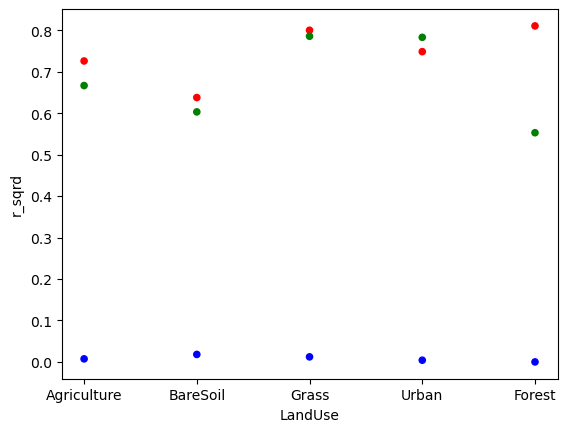

In [51]:
colors = {"WASIM":"blue",
          "SSEB": "red", 
          "EEFlux": "green"}
df.plot.scatter(x = "LandUse", y = "r_sqrd", c = df["Model"].map(colors))

### Correlation Matrix

In [52]:
# Correlation Matrix
ds = xr.Dataset({"SEBAL": eta_day, "WASIM": wasim, 
                     "SSEB": SSEB_raster, "EEFlux": eeflux})

correlation_matrix = ds.to_dataframe().corr()
correlation_matrix = correlation_matrix.iloc[2:6,2:6]
#xr.corr(eta_day, wasim)
correlation_matrix

,SEBAL,WASIM,SSEB,EEFlux
SEBAL,1.000000,0.469224,0.898577,0.893282
WASIM,0.469224,1.000000,0.568202,0.488115
SSEB,0.898577,0.568202,1.000000,0.897498
EEFlux,0.893282,0.488115,0.897498,1.000000


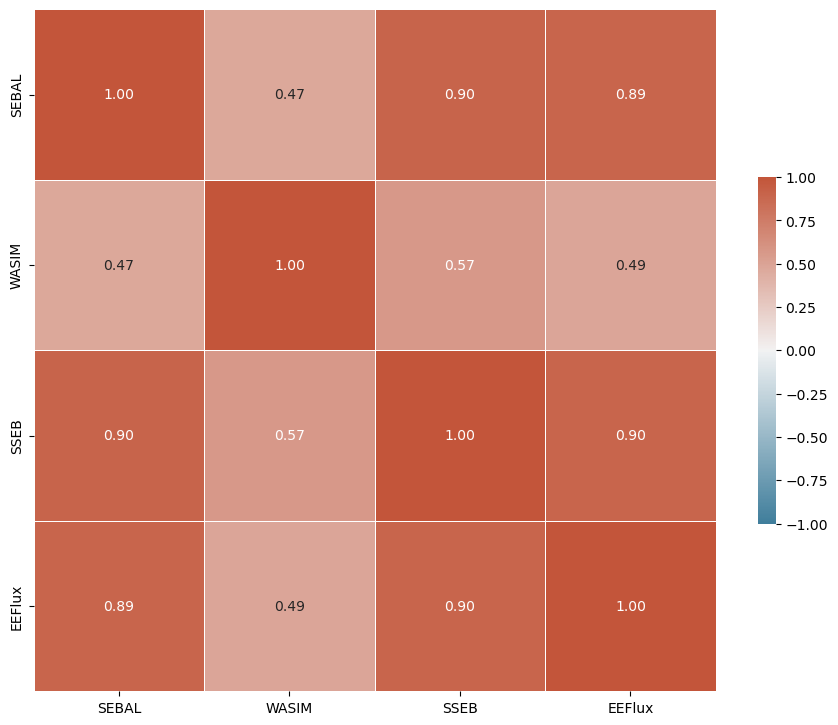

In [53]:
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the full correlation matrix heatmap with annotations
sns.heatmap(correlation_matrix, cmap=cmap, vmax=1, vmin=-1, center=0,
            square=True, linewidths=.5, annot=True, fmt=".2f", cbar_kws={"shrink": .5})

# Show the plot
plt.show()